<a href="https://colab.research.google.com/github/awangberg/AdvLinearAlgebra/blob/master/Project_4_Case_1_Solving_for_a_known_trigonometric_function_using_Singular_Values_or_Best_Fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#  Libraries that we'll need:
import numpy as np
import sympy as sym
from scipy import misc
from scipy import linalg
from PIL import Image
import imageio
import matplotlib.pyplot as plt
# importing "random" for random operations 
import random 

#  Singular Value Decomposition and Best Fit

We look at some data generated here from three sources:

*   Case 0:  A known polynomial function f(x) = 4 - 3x^2 + 5x^6
*   Case 1:  A known trigonometric function f(x) = 4 - 2*cos(x) + cos^2 (x)
*   Case 2:  An unknown matrix of data M (specified below)
*   Case 3:  An interesting case.

#  Case 1:  
We generate data for the polynomial function 
$$f(x) = 4 -3\cos(x) + \cos^2 (x)$$ 
We know two things: The input (x) and the output (f(x)) for that input.  Pretend we know the (x, f(x)) pairs for **a lot** of different points, say $3$ of them.

We want to find out what combination of polynomials $1, x, x^2, x^3, x^4, x^5, x^6, x^7$ and $x^8$ best matches the data.  For each input/output pair $(x, f(x))$, we generate one row of data in the system $Ac = b$:

$$ [  c_0 * 1 + c_1 * x + c_2 * x^2 + c_3 * x^3 + ... c_8 x^8 = f(x) ] $$

or

$$ \left[ \begin{array}{ccccccccc} 1 & x & x^2 & x^3 & x^4 & x^5 & x^6 & x^7 & x^8 \end{array} \right] \left( \begin{array}{c} c_0 \\ c_1 \\ c_2 \\ c_3 \\ c_4 \\ c_5 \\c_6 \\ c7 \\ c8 \\ \end{array} \right) = \left[ f(x) \right] $$


Be careful -- the unknowns are the coefficients in front - the $c_0, c_1, c_2, ..., c_8$ values.  Since we know $x$, then we know $x, x^2, x^3, x^4, ... x^8$. And we know the output $f(x)$ for that row.

So, if we know $x=2$ and $f(2) = 312$, then we populate the row as:

$$ [  c_0*1  + c_1*2 + c_2*4 + c_3*8 + ... + c_8*256 = 312 ] $$

or
$$ \left[ \begin{array}{ccccccccc} 1 & 2 & 4 & 8 & 16 & x32 & 64 & 128 & 256\end{array} \right] \left( \begin{array}{c} c_0 \\ c_1 \\ c_2 \\ c_3 \\ c_4 \\ c_5 \\c_6 \\ c_6 \\ c_8 \\ \end{array} \right) = \left[ 312 \right] $$

where the vector $\vec{c}$ contains the unknowns $c_0, c_1, c_2, \ldots c_8$

So... let's generate the matrix:



In [3]:
#We'll generate random points of data for our system.
#The actual points for the system will be stored in actual_data_x, actual_data_y
#
#We'll also set up a matrix system with augmented matrix M|b for using the system
#of best-fit:

best_fit_data = []
output_data = []
actual_data_x = []
actual_data_y = []
for i in range(3):
    # pick a random number between -5 and 5
    x = 4*np.pi*random.random() - 2*np.pi
    f = 4 - 2*np.cos(x) + np.cos(x)**2
    best_fit_data.append([1, x, x**2, x**3, x**4, x**5, x**6, x**7, x**8])
    output_data.append([f])
    actual_data_x.append(x)
    actual_data_y.append(f)
# Now, put the data into M and b:
M = np.matrix(best_fit_data)
b = np.matrix(output_data)
#show the first five entries of b:
b[:3]

matrix([[6.76190903],
        [3.0001101 ],
        [6.90657307]])

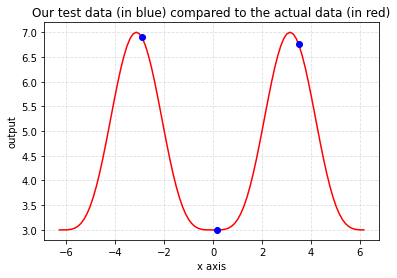

In [4]:
# We'll specify that x is a variable:
x = sym.symbols('x')
xdata = []
xdata = np.array(range(100))/(100/(4*np.pi)) - 2*np.pi
fdata = 4 - 2*np.cos(xdata) + np.cos(xdata)**2

# Create the plot in red, and our datapoints in blue:  
plt.plot(xdata,fdata, color='red') + plt.plot(actual_data_x, actual_data_y, 'bo')

# Add a title
plt.title('Our test data (in blue) compared to the actual data (in red)')

# Add X and y Label
plt.xlabel('x axis')
plt.ylabel('output')

# Add a grid
plt.grid(alpha=.4,linestyle='--')


In [5]:
#  Find the best-fit line using any of the two methods that work from last class period:
#
#  Method 1:  M c = b  leads to    c = (M^T M)^(-1) M^T  b
c = linalg.inv(M.transpose() * M) * M.transpose() * b
c


matrix([[ 3.60408995e+00],
        [-1.34353882e+00],
        [ 1.46380485e+00],
        [-1.05841203e-01],
        [-2.50044540e-03],
        [-1.34558575e-03],
        [ 8.55837920e-04],
        [ 1.45255049e-03],
        [ 1.28293904e-04]])

In [6]:
#  Let's see how close this actually gets us by comparing the original b vector to the result of Mc:
"b is in the left column, M*c is in the middle column, and the right column gives b - M*c"
#We make a matrix, whose columns are [  b,  M*c,  b - M*c ]
#Then, we find the magnitude of these vectors.  If b-M*c is close to zero, we have a really good fit:
[((b.transpose()*b)[0,0])**0.5,  (((M*c).transpose() * (M*c))[0,0])**0.5,  (((b-M*c).transpose() * (b-M*c))[0,0])**0.5 ]

[10.120515098194703, 32.871190520634784, 23.077150883162243]

In [0]:
#  Method 2:  use singular value decomposition.
#
#  For this method, we use SVD on the data matrix M:
U, S, Vh = linalg.svd(M, full_matrices=True)

In [8]:
#  Show the matrix U:
U


array([[-9.79300793e-01,  2.02410369e-01, -1.78408351e-09],
       [-3.83933222e-09, -2.73896277e-08, -1.00000000e+00],
       [-2.02410369e-01, -9.79300793e-01,  2.75998045e-08]])

In [9]:
#Show the matrix S:  (but notice only the singular values are stored, not the entire matrix)
S

array([2.35037187e+04, 3.19176540e+03, 1.01067984e+00])

In [10]:
#Show the matrix Vh:
Vh

array([[-5.02776255e-05, -1.20272218e-04, -5.81443390e-04,
        -1.55734702e-03, -6.81850369e-03, -1.97628379e-02,
        -8.08096071e-02, -2.47551888e-01, -9.65270961e-01],
       [-2.43404622e-04,  1.11865498e-03, -1.85108456e-03,
         1.03716361e-02, -1.30210568e-02,  9.85075000e-02,
        -7.71159568e-02,  9.61982335e-01, -2.42193171e-01],
       [-9.89432992e-01, -1.43458724e-01, -2.07999639e-02,
        -3.01659124e-03, -4.35532842e-04, -7.01559306e-05,
         4.69303956e-06, -6.24391862e-05,  1.06940107e-04],
       [-3.05990776e-03, -1.40855489e-03,  1.02966535e-02,
         9.99886515e-01,  1.23599028e-04, -1.05069193e-03,
         6.71969600e-04, -1.03451262e-02,  9.98415906e-04],
       [-1.07003673e-03,  6.22718860e-03, -1.30904486e-02,
         1.40505084e-04,  9.99786794e-01,  1.14528917e-03,
        -1.55209444e-03,  1.08094294e-02, -9.72106032e-03],
       [-5.04518243e-03,  2.01253746e-02,  9.82939487e-02,
        -9.97570241e-04,  1.15320266e-03,  9.899211

In [11]:
#  The 2nd singular value is:
S[1]

3191.765398127791

In [12]:
# We can also compare the matrix reconstructed from the SVD and the original matrix M:

#First, recast S as a matrix instead of a vector:
sigma = np.zeros((U.shape[1], Vh.shape[0]))
for i in range(min(sigma.shape)):
     sigma[i, i] = S[i]
a1 = np.dot(U, np.dot(sigma, Vh))
#does a1 approximate M?
np.allclose(M, a1)

True

In [0]:
#  If there are 3 non-zero singular values, we'll use the upper (3x3) submatrix of sigma and the
#  correspondingly sized submatrices for U and Vh.
#  We'll have to divide each of U, sigma, and Vh into matrices we want to use (U_use, Sigma_use, and Vh_use)
#  and the remaining blocks along the diagonal which we'll want to discard (U_d, Sigma_d, Vh_d)
useSigs = 3
(Vrows, Vcols) = Vh.shape
(Urows, Ucols) = U.shape
U_use = U[:Urows, :useSigs]
Vh_use = Vh[:Vrows, :useSigs]
sigma_use = sigma[:useSigs, :useSigs]

U_d = U[:Urows, useSigs:]
Vh_d = Vh[:Vrows, useSigs:]
sigma_d = sigma[useSigs:, useSigs:]

In [14]:
#  We should be able to figure out the size of U and Vh that we'll use:
#
#  U S Vh  =   [         .     ] [             .         ]  [            .      ]
#              [ U_use   .     ] [  sigma_use  .         ]  [   Vh_use   .      ]
#              [         . U_d ] [.......................]  [            . Vh_d ]
#              [         .     ] [             . sigma_d ]  [            .      ]
#
#
#  Check that U_use, sigma_use, and Vh_use are the right sizes, as well as U_d, sigma_d, and Vh_d
U_use.shape
#sigma_use.shape
#Vh_use.shape
#U_d.shape
#sigma_d.shape
#Vh_d.shape

(3, 3)

In [15]:
#  If we use Singular Value Decomposition to break down A as a product of matrices
#  A = U sigma Vh.conjugate_transpose()
#  Then the part of A which corresponds to non-zero singular values is:
#  A_use = U_use sigma_use Vh_use.conjugate_transpose()
#
#  So, the equation Ax = b becomes:  (U_use sigma_use Vh_use.conjugate_transpose()) x = b
#  or
#  svd_sol = (U_use sigma_use Vh_use.conjugate_transpose()).inverse() b
#  or
#  svd_sol = Vh_use * Sigma_use.inverse() * U_use.transpose() * b
#  (since Vh_use.conjugate_transpose() = Vh_use.inverse() and U_use.transpose() = U_use.inverse() )
svd_sol = (Vh_use @ linalg.inv(sigma_use) @ U_use.transpose()) @ b
svd_sol

matrix([[ 1.72618155e-03],
        [ 5.49296610e-03],
        [ 6.23228716e-02],
        [-3.05612417e-02],
        [ 3.88476294e-02],
        [-2.91808821e-01],
        [ 2.30988290e-01],
        [-2.84827539e+00],
        [ 7.44249157e-01]])

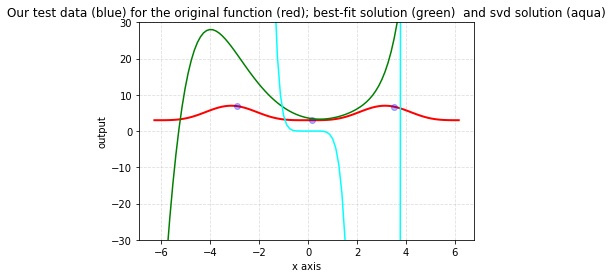

In [24]:
#Show a plot of the solutions using the best-fit method, and the SVD method:

# We'll specify that x is a variable:
x = sym.symbols('x')
xdata = []
xdata = np.array(range(100))/(100/(4*np.pi)) - 2*np.pi
fdata = 4 - 2*np.cos(xdata) + np.cos(xdata)**2
svd_fit = svd_sol[0,0] + svd_sol[1,0]*xdata + svd_sol[2,0]*(xdata**2) + svd_sol[3,0]*(xdata**3) + svd_sol[4,0]*(xdata**4) + svd_sol[5,0]*(xdata**5) + svd_sol[6,0]*(xdata**6) + svd_sol[7,0]*(xdata**7)+svd_sol[8,0]*(xdata**8)
best_fit = c[0,0] + c[1,0]*xdata + c[2,0]*(xdata**2) + c[3,0]*(xdata**3) + c[4,0]*(xdata**4) + c[5,0]*(xdata**5) + c[6,0]*(xdata**6) + c[7,0]*(xdata**7) + c[8,0]*(xdata**8)
# Create the actual plot in red, and our datapoints in blue,
# the best-fit method in green, and the svd solution in aqua:  
plt.plot(xdata,fdata, color='red', linewidth=2 ) + plt.plot(actual_data_x, actual_data_y, 'bo', alpha=0.3)+plt.plot(xdata,best_fit, color='green') + plt.plot(xdata, svd_fit, 'aqua')

#Restrict the output values to this range:
plt.ylim(-30,30)
# Add a title
plt.title('Our test data (blue) for the original function (red); best-fit solution (green)  and svd solution (aqua)')

# Add X and y Label
plt.xlabel('x axis')
plt.ylabel('output')

# Add a grid
plt.grid(alpha=.4,linestyle='--')


In [0]:
plt.plot()